In [22]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
import re
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis.gensim
import pyLDAvis
from gensim.models import CoherenceModel


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gsevr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
df_holc = pd.read_csv('holc_output.csv')
df_comm = pd.read_csv('comments.csv', delimiter=';')

df = pd.concat([df_comm, df_holc], axis=1)

df.drop(df.columns[1],axis=1,inplace=True)
df.drop(df.columns[1],axis=1,inplace=True)

df

,comment,unic_sentiment,unic_score
0,it is very possible that social media have alr...,neg,0.97
1,@paul i believe that accurate beliefs are abso...,pos,0.89
2,@chris v our cognitive systems are not designe...,neg,0.88
3,@paul absolutely agree. i don’t think even lib...,neg,0.92
4,@paul belief is a a trait that developed late ...,neg,0.91
...,...,...,...
1443,purdue pharma's sackler family paid $6 billion...,neu,0.64
1444,"unless prevented, the nihilistic qualities of ...",neu,0.69
1445,"putting ""the"" government in charge of things i...",neg,0.55
1446,this is just another example of 'extinction by...,neg,0.51


In [24]:
def preprocess(text):
    t = text.lower()
    # t = re.sub('_',r'',t)
    # t = re.sub('\d+',r'',t)
    t = re.sub(r'@[^ ]*',r'',t)
    t = re.sub(r'\W+',r' ',t)
    t = re.sub(r'(could|would|like|)', '', t)
    t = re.sub(r'\b\w{1,3}\b', '', t)
    t = re.sub(r'humans',r'human',t)
    stopwords_list = stopwords.words('english')
    txt = ' '.join([word for word in t.split() if word not in stopwords_list])
    return txt

lemmatizer = WordNetLemmatizer()



df['pre_com'] = [' '.join([lemmatizer.lemmatize(preprocess(email))])
                 .strip() for email in df['comment']]

In [25]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = df.pre_com.values.tolist()
data_words = list(sent_to_words(data))
        

c:\Users\gsevr\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


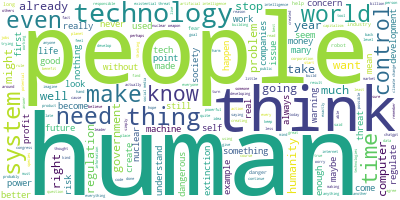

In [26]:
long_string = ','.join(list(df.pre_com.values))

wordcloud = WordCloud(background_color="white", max_words=250, contour_width=3, contour_color='steelblue')

wordcloud.generate(long_string)

wordcloud.to_image()

In [27]:
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [28]:
num_topics = 4

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=1
                                       )

pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

[(0,
  '0.008*"human" + 0.006*"people" + 0.004*"technology" + 0.004*"even" + '
  '0.004*"world" + 0.004*"government" + 0.004*"think" + 0.004*"know" + '
  '0.003*"problem" + 0.003*"nuclear"'),
 (1,
  '0.011*"human" + 0.007*"people" + 0.006*"technology" + 0.005*"world" + '
  '0.005*"make" + 0.005*"think" + 0.004*"even" + 0.004*"want" + '
  '0.003*"companies" + 0.003*"control"'),
 (2,
  '0.010*"human" + 0.005*"people" + 0.005*"think" + 0.005*"technology" + '
  '0.004*"need" + 0.003*"even" + 0.003*"threat" + 0.003*"already" + '
  '0.003*"time" + 0.003*"tech"'),
 (3,
  '0.009*"human" + 0.009*"people" + 0.005*"think" + 0.004*"already" + '
  '0.004*"nuclear" + 0.003*"technology" + 0.003*"many" + 0.003*"need" + '
  '0.003*"extinction" + 0.003*"stop"')]


In [29]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'test_html.html')

In [34]:
lambd = 0.3 # a specific relevance metric value

all_topics = {}
num_topics = lda_model.num_topics 
num_terms = 5 

for i in range(1,num_topics+1): ## Correct range
    topic = vis.topic_info[vis.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
pd.DataFrame(all_topics)

,Topic 1,Topic 2,Topic 3,Topic 4
0,world,people,human,problem
1,human,field,really,government
2,computers,risk,sense,made
3,make,many,better,know
4,technology,extinction,warning,olds


In [31]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.577189445597488

Coherence Score:  0.5262578927082749


In [32]:
# ltup = []

# for topics in range(1,10):
#     lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=topics,
#                                        random_state=1
#                                        )
    
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()

#     ltup.append((topics, coherence_lda))

# pprint(ltup)
    
